# Imports 🔊

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e9/sample_submission.csv
/kaggle/input/playground-series-s5e9/train.csv
/kaggle/input/playground-series-s5e9/test.csv


In [2]:
sample = pd.read_csv('/kaggle/input/playground-series-s5e9/sample_submission.csv')
train = pd.read_csv('/kaggle/input/playground-series-s5e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e9/test.csv')

In [3]:
train.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [4]:
train.columns

Index(['id', 'RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality',
       'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore',
       'TrackDurationMs', 'Energy', 'BeatsPerMinute'],
      dtype='object')

# Data exploration 🔎

Target value distribution looks kinda Gaussian, so I decided not to

Text(0.5, 1.0, 'Histogram and mean')

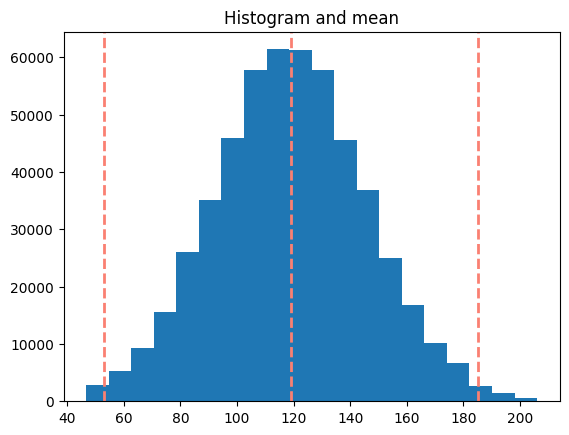

In [5]:
plt.hist(train['BeatsPerMinute'], bins=20)
mean_val = train['BeatsPerMinute'].mean()
std = np.std(train['BeatsPerMinute'])
plt.axvline(mean_val, color='salmon', linestyle='--', linewidth=2)
plt.axvline(mean_val + 2.5 * std, color='salmon', linestyle='--', linewidth=2)
plt.axvline(mean_val - 2.5 * std, color='salmon', linestyle='--', linewidth=2)
plt.title('Histogram and mean')

Text(0.5, 1.0, 'Boxplot (shows outliers)')

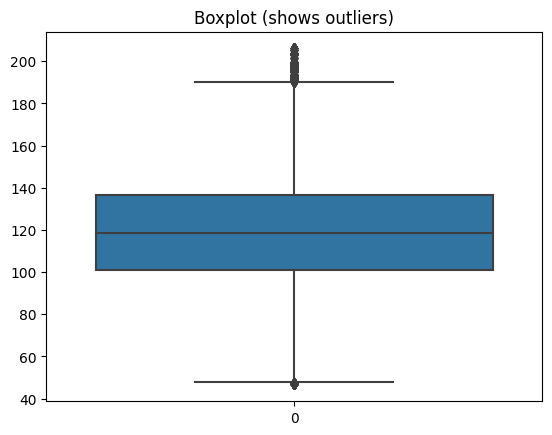

In [6]:
import seaborn as sns
sns.boxplot(train['BeatsPerMinute'])
plt.title('Boxplot (shows outliers)')

# Removing Outliers 🧹

Most of the data points lies inside of the range of box plot. That means the data outside is likely contains not much of a useful information. Lets clean that up

In [7]:
upper_bound = 185
lower_bound = 50

len_before = len(train)
train = train[(train['BeatsPerMinute'] > lower_bound) & (train['BeatsPerMinute'] < upper_bound)]
len_after = len(train)

print(f'{(1 - len_after/len_before) * 100:.2f}% of original data was removed')

0.88% of original data was removed


Text(0.5, 1.0, 'Boxplot of clean data')

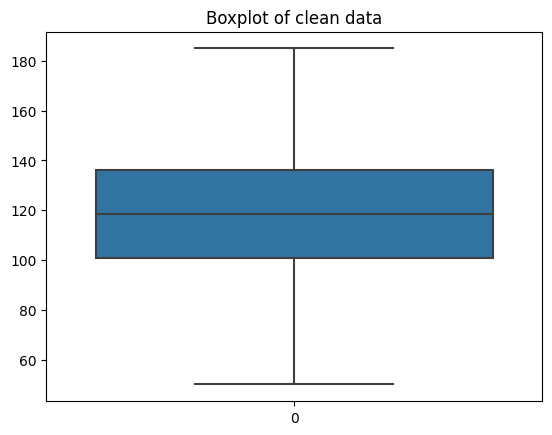

In [8]:
sns.boxplot(train['BeatsPerMinute'])
plt.title('Boxplot of clean data')

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, SplineTransformer
from catboost import CatBoostRegressor

In [10]:
X, y = train.drop(['BeatsPerMinute'], axis=1), train['BeatsPerMinute']

# Data augmentation 📊

In [11]:
X

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333
...,...,...,...,...,...,...,...,...,...,...
524159,524159,0.796831,-13.405645,0.023500,0.504738,0.000001,0.191414,0.668079,135528.3189,0.004400
524160,524160,0.975000,-12.132914,0.077379,0.069462,0.262320,0.124818,0.288946,240709.3918,0.447067
524161,524161,0.542958,-1.357000,0.071390,0.168978,0.000001,0.313912,0.586868,344858.2321,0.718800
524162,524162,0.637192,-7.411331,0.113086,0.000005,0.061946,0.287963,0.368891,322710.3187,0.944267


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

# Model + Hyperparams optimization 📈

In [13]:
regressor = make_pipeline(StandardScaler(), SplineTransformer(degree=3, n_knots=3), CatBoostRegressor())
param_grid = { 'catboostregressor__learning_rate': (0.01, 0.05, 0.1),
                'catboostregressor__l2_leaf_reg': (1, 3, 5),
                'catboostregressor__depth': [4, 6, 8],
                'catboostregressor__n_estimators': [100, 1000, 2000],
                'catboostregressor__verbose':[False]
               }
search = GridSearchCV(regressor, param_grid, cv=5, verbose=2, scoring='neg_root_mean_squared_error',refit=True)
search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END catboostregressor__depth=4, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01, catboostregressor__n_estimators=100, catboostregressor__verbose=False; total time=  13.0s
[CV] END catboostregressor__depth=4, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01, catboostregressor__n_estimators=100, catboostregressor__verbose=False; total time=  12.8s
[CV] END catboostregressor__depth=4, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01, catboostregressor__n_estimators=100, catboostregressor__verbose=False; total time=  12.9s
[CV] END catboostregressor__depth=4, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01, catboostregressor__n_estimators=100, catboostregressor__verbose=False; total time=  13.0s
[CV] END catboostregressor__depth=4, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01, catboostregressor__n_estimat

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('splinetransformer',
                                        SplineTransformer(n_knots=3)),
                                       ('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x7d7743139890>)]),
             param_grid={'catboostregressor__depth': [4, 6, 8],
                         'catboostregressor__l2_leaf_reg': (1, 3, 5),
                         'catboostregressor__learning_rate': (0.01, 0.05, 0.1),
                         'catboostregressor__n_estimators': [100, 1000, 2000],
                         'catboostregressor__verbose': [False]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [14]:
search.best_score_

-25.66917510891301

In [15]:
search.best_params_

{'catboostregressor__depth': 6,
 'catboostregressor__l2_leaf_reg': 1,
 'catboostregressor__learning_rate': 0.01,
 'catboostregressor__n_estimators': 1000,
 'catboostregressor__verbose': False}

# Prediction 🔎

In [16]:
def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

In [17]:
pred = search.predict(X_val)
rmse(y_val, pred)

25.72179785478264

In [18]:
pred = pd.DataFrame({
    'id': test.id,
    'BeatsPerMinute': search.predict(test)
})
pred.to_csv('best_catboost_prediction_no_idx.csv', index=False)